In [2]:
import pytc
import plotly.plotly as py
import ipywidgets as widgets

from IPython.display import display, clear_output
from IPython.html.widgets import interactive
from plotly.widgets import GraphWidget
import seaborn as sns

%matplotlib inline

In [99]:
class ParamCollect():
    def __init__(self, gui, container, fitter):
        
        self._gui = gui
        self._exp_id = ''
        self._exp_val = ''
        self._widgets = []
        self._fitter = fitter
        self._container = container
        self._parameters = {}
        self._models = {"blank" : pytc.models.Blank,
          "single site" : pytc.models.SingleSite,  
          "single site competitor" : pytc.models.SingleSiteCompetitor, 
          "binding polynomial" : pytc.models.BindingPolynomial}
        self._current_model = ''
        
    def remove_exp(self, b):
        """
        remove experiment from analysis and close widgets
        """
        try:
            self._gui.remove_experiment(self._exp_id)
        except:
            clear_output()
            print("no experiment linked")
        
        self._widgets[3].close()
        
        for i in self._container:
            if self._exp_id == i[0]._exp_id:
                self._container.remove(i)
    
    def parameters(self):
        """
        get parameters for experiment
        """
        pass
        
    def create_exp(self):
        """
        create a new pytc experiment
        """
        self._exp_val = self._widgets[0].value
        if self._exp_val:
            self._current_model = self._widgets[1].value
            self._exp_id = pytc.ITCExperiment(self._exp_val, self._current_model)
            self.parameters()
        else:
            clear_output()
            print("no exp data given")
            
    def update_exp(self):
        """
        update experiment if changed
        """
        
        if self._current_model != self._widgets[1].value:
            self.create_exp()
        else:
            print("nothing to update")
        
            
    def exp_id(self):
        """
        return experiment id
        """
        
        return self._exp_id
    
    
    def gen_sliders(self):
        """
        generate sliders for each experiment, give option to link to global.
        """
        
        pass
    
    def gen_exp(self):
        """
        generate widgets for experiment.
        """
        pass
    
class Experiments(ParamCollect):
    """
    create experiment object and generate widgets
    """
    def __init__(self, gui, container, fitter):
        super().__init__(gui, container, fitter)
    
    def parameters(self):
        """
        generate local parameters for experiment.
        """
        
        global_param, local_param = self._fitter.param_names
        global_guesses, local_guesses = self._fitter.param_guesses
        global_ranges, local_ranges = self._fitter.param_ranges
        global_fixed, local_fixed = self._fitter.fixed_param 
        
        self._parameters = {"name": local_param, 
                            "value": local_guesses, 
                            "ranges": local_ranges, 
                            "fixed": local_fixed}
        
        return self._parameters
    
    def gen_sliders(self):
        """
        generate sliders for each experiment, give option to link to global.
        """
        
        pass
    
    def gen_exp(self):
        """
        generate widgets for experiment.
        """
        exp_field = widgets.Text(description = "exp: ")
        model_drop = widgets.Dropdown(options = self._models, value = self._models["blank"])

        rm_exp = widgets.Button(description = "remove experiment")
        rm_exp.on_click(self.remove_exp)

        exp_box = widgets.HBox(children = [exp_field, model_drop, rm_exp])
        self._widgets.extend([exp_field, model_drop, rm_exp, exp_box])
        
        return exp_box


class Interface:
    
    def __init__(self,fitter):
        """
        """
        
        self._global_sliders = {}
        self._local_sliders = []
        self._fitter = fitter
        self._experiments = []
        self._param_button = widgets.Button(description = 'Return Paramaters')
        
    def view_exp(self):
        
        return self._experiments
    
    def add_experiment(self,expt):
        
        self._fitter.add_experiment(expt)
        self._experiments.append(expt)
        
    def remove_experiment(self, expt):
        
        self._fitter.remove_experiment(expt)
        self._experiments.remove(expt)
            
    def reset_sliders(self):
        
        for i in self._local_sliders:
            for slider in i:
                i[slider].close()
            i.clear()
        self._param_button.close()
    
    def build_interface(self):
        """
        """

        global_param, local_param = self._fitter.param_names
        global_guesses, local_guesses = self._fitter.param_guesses
        global_ranges, local_ranges = self._fitter.param_ranges
        global_fixed, local_fixed = self._fitter.fixed_param 
        
        all_widgets = {}
        
        for p in global_param:
        
            g_min = global_ranges[p][0]
            g_max = global_ranges[p][1]
            g_val = global_guesses[p]
            
            self._global_sliders[p] = widgets.FloatSlider(min=g_min,max=g_max,value=g_val)
            
            all_widgets["{}".format(p)] = self._global_sliders[p]
    
        for i in range(len(self._experiments)):            
            
            self._local_sliders.append({})
        
            for p in local_param[i]:
            
                g_min = local_ranges[i][p][0]
                g_max = local_ranges[i][p][1]
                g_val = local_guesses[i][p]
                
                self._local_sliders[-1][p] = widgets.FloatSlider(min=g_min,max=g_max,value=g_val)
        
                all_widgets["{},{}".format(p,i)] = self._local_sliders[-1][p]

        w = widgets.interactive(self._update,**all_widgets)
        
        #self._param_button = widgets.Button(description = 'Return Paramaters')
        self._param_button.on_click(self.get_param)
                        
        display(w, self._param_button)

    def _update(self,**kwargs):
        """
        """
        
        for k in kwargs.keys():
            if len(k.split(",")) == 1:
                self._fitter.update_guess(k,kwargs[k])
            else:
                
                param_name = k.split(",")[0]
                expt = self._experiments[int(k.split(",")[1])]
                self._fitter.update_guess(param_name,kwargs[k],expt)
       
        self._fitter.fit()
        self._fitter.plot()
        #self.get_param()
        
    def get_param(self, b):
        
        #clear_output()
        display(self._fitter.fit_param[1])
        
        #fit error

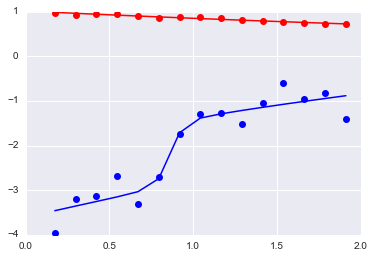

In [100]:
exp_w = []
f = pytc.GlobalFit()
gui = Interface(f)

def rm_last(b):

    if exp_w:
        last_exp = exp_w[-1]
        last_exp[1].close()
        try:
            gui.remove_experiment(last_exp[0].exp_id())
        except:
            pass

        exp_w.remove(last_exp)

def gen_exp(b):
    
    gui.reset_sliders()
    clear_output()
    
    for i in exp_w:
        try:
            exp = i[0]
            
            if not exp.exp_id():
            
                exp.create_exp()

                gui.add_experiment(exp.exp_id())

                param = i[0].parameters()
                name = param["name"]
                
            else:
                #exp.update_exp()
                pass
        except:
            print("no data added.")


        #f.link_to_global(exp, "dilution_heat", "global_heat")
        #f.link_to_global(exp, "dilution_intercept", "global_intercept")

    gui.build_interface()
    #gui.get_param()

def clear_exp(b):

    for i in exp_w:
        try:
            i[1].close()
            gui.remove_experiment(i[0].exp_id())
        except:
            pass
        
        exp_w.remove(i)
        
    gui.reset_sliders()
    clear_output()

    
def gen_exp_list(exp_list):
    
    for i in range(len(exp_w)):
        exp = exp_w[i][0]
        exp_list['exp {}'.format(i)] = exp.exp_id
        
    return exp_list

def print_param(b):
    
    param = gui.get_param()
    
    display(param[1])

def add_field(b):
    
    clear_output()
    gui.reset_sliders()
    exp_object = Experiments(gui, exp_w, f)
    show = exp_object.gen_exp()

    exp_w.append([exp_object, show])

    display(show)
        
    # true false??? each time add_field clicked set true, each time analyze clicked set false.
        
ENTRY_W = '200px'

add_exp_field_b = widgets.Button(description = "Add an Experiment")
add_exp_field_b.layout.width = ENTRY_W
add_exp_field_b.on_click(add_field)

rmv_last_field = widgets.Button(description = "Remove Last Experiment")
rmv_last_field.layout.width = ENTRY_W
rmv_last_field.on_click(rm_last)

exp_object = Experiments(gui, exp_w, f)
show = exp_object.gen_exp()

exp_w.append([exp_object, show])

analyze_widget = widgets.Button(description = "Analyze")
analyze_widget.on_click(gen_exp)

clear_widget = widgets.Button(description = "Clear", value = False)
clear_widget.on_click(clear_exp)

experiments_layout = widgets.Layout(display = "flex", 
                      flex_flow = "row", 
                      align_items = "stretch")

experiments = widgets.Box(children = [add_exp_field_b, rmv_last_field], 
                                      layout = experiments_layout)
parent = widgets.Box(children = [analyze_widget, clear_widget, experiments, show])

display(parent)

test-data/real-blank-match.DH

test-data/blank.DH

In [82]:
exp_w

[[<__main__.Experiments at 0x114136048>,

In [84]:
exp = exp_w[0][1]

In [85]:
exp